DSCI100 002, Group 18

Group Members: Jimmy Choy, Jennifer Law, Heather Lu, Elise Wong



**Sleep Disorder Diagnosis**

**Introduction**

Sleep is fundamental to human life and health, but many people suffer from sleep disorders. Two sleep disorders are sleep apnea–where breathing stops during sleep–and insomnia, where people have difficulty falling asleep. Sleep disorders can be influenced by lifestyle and are often comorbid with chronic health disorders. 

In our project, we will utilise the Sleep Health and Lifestyle Dataset, which includes information pertaining to sleep, lifestyle, cardiovascular health, and sleep disorders. We aim to determine: “How can lifestyle and physiological measures be used to determine the absence or presence of sleep disorders?” 

**Methods**

We will predict the diagnosis (sleep disorder or none) via classification as the diagnosis variable is categorical. 


**EXPLORATORY DATA ANALYSIS**

In [53]:
library(tidyverse)
library(tidymodels)
library(GGally) #for ggpairs

set.seed(100)

In [54]:
url <- "https://drive.google.com/uc?export=download&id=1oltvINJVaLEg0raTdWG2IoFCf6w4h5vD"
sleep_data <- read_delim(url,
                         delim = ",")
head(sleep_data)

Rows: 374 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


**Cleaning & Wrangling**

In [2]:
#adding a period to replace spaces in the headers
colnames(sleep_data) <- make.names(colnames(sleep_data))

Our model excludes "Gender", "Occupation" and “BMI category”. We observed imbalanced proportions in these variables, which will introduce bias to the model’s performance. They are also excluded because they are factor variables. We restrict our predictors to only numerical variables for consistency in analysis. “Person ID” is also excluded as it labels each observation and should not be used as a predictor. The "Blood Pressure" variable is divided into systolic and diastolic variables to ensure that each cell contains one value only.

In [3]:
#separating bp column
sleep_data <- separate(sleep_data,
    col = Blood.Pressure,
    into = c("Systolic.BP", "Diastolic.BP"),
    sep = "/",
    convert = TRUE) 

In [4]:
#removing unwanted predictors
sleep_data_2 <- sleep_data |>
    select(-Person.ID, -Gender, -Occupation, -BMI.Category)
head(sleep_data_2)

Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Sleep.Disorder
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
27,6.1,6,42,6,126,83,77,4200,None
28,6.2,6,60,8,125,80,75,10000,None
28,6.2,6,60,8,125,80,75,10000,None
28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
28,5.9,4,30,8,140,90,85,3000,Insomnia


“Insomnia” and “sleep apnea” are combined to a single value, “Sleep Disorder”, in the Diagnosis column so that the number of subjects with a sleep disorder is similar to the number of subjects without one.

In [5]:
#combining 'sleep apnea' and 'insomnia' into 'sleep disorders'
sleep_apnea_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Sleep Apnea") |>
select(-Sleep.Disorder)
sleep_apnea_tidy <- data.frame(sleep_apnea_untidy, Diagnosis = "Sleep Disorder")

insomnia_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Insomnia") |>
select(-Sleep.Disorder)
insomnia_tidy <- data.frame(insomnia_untidy, Diagnosis = "Sleep Disorder")

none_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "None") |>
select(-Sleep.Disorder)
none_tidy <- data.frame(none_untidy, Diagnosis = "None")

tidy_sleep_data <- rbind(sleep_apnea_tidy, insomnia_tidy, none_tidy)

head(tidy_sleep_data)

,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Diagnosis
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
2,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
3,29,6.5,5,40,7,132,87,80,4000,Sleep Disorder
4,29,6.0,6,30,8,120,80,70,8000,Sleep Disorder
5,30,6.4,5,35,7,130,86,78,4100,Sleep Disorder
6,31,7.7,7,75,6,120,80,70,8000,Sleep Disorder


**Table 1: Summary Count**

The table below represents the number of observations and percentages for each class in the training set.

In [60]:
summary_table_1 <- tidy_sleep_data |>
  group_by(Diagnosis) |>
  summarize(count = n(), percentage = n()/nrow(sleep_train)*100)

summary_table_1

Diagnosis,count,percentage
<chr>,<int>,<dbl>
None,219,78.21429
Sleep Disorder,155,55.35714


**Table 2: Summary Means**

The table below represents the means for each predictor in the training set.

In [34]:
summary_table_2 <- summarize(tidy_sleep_data, across(Age:Daily.Steps, mean))
summary_table_2

Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42.18449,7.132086,7.312834,59.17112,5.385027,128.5535,84.64973,70.16578,6816.845


**Table 3: Summary Means Diagnosis**

The table below shows the means for each predictor in the training set, split between diagnosis.

In [43]:
summary_table_3 <- tidy_sleep_data |>
    group_by(Diagnosis) |>
    summarize(across(Age:Daily.Steps, mean))

summary_table_3

Diagnosis,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
None,39.03653,7.358447,7.625571,57.94977,5.114155,124.0457,81.00000,69.01826,6852.968
Sleep Disorder,46.63226,6.812258,6.870968,60.89677,5.767742,134.9226,89.80645,71.78710,6765.806


**Figure 1: Exploratory Visualization**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



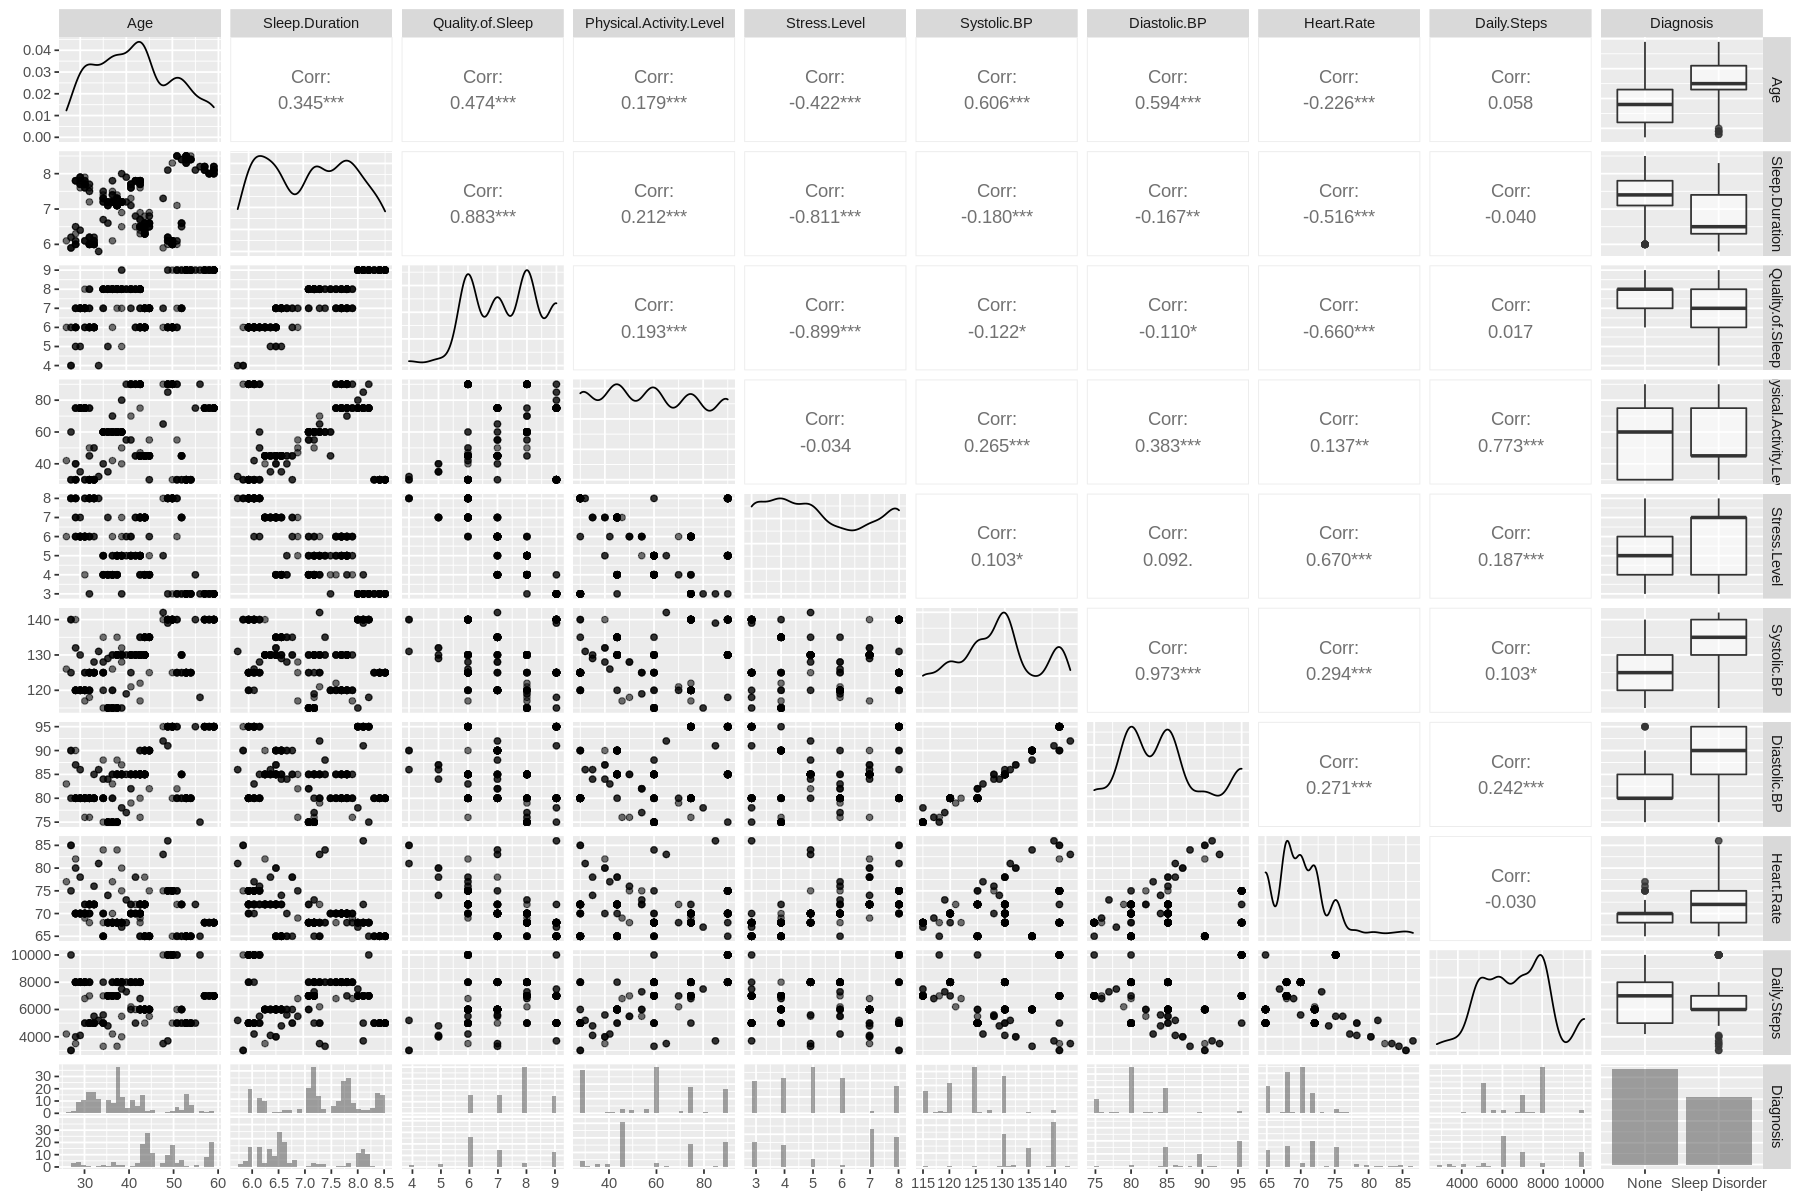

In [36]:
comparison_plot <- tidy_sleep_data |>
    ggpairs(mapping = aes(alpha = 0.4))

comparison_plot

**Figure Legend**

A ggpairs plot is used to compare the "Sleep Disorder" and "None" observations against each predictor variable. The ideal predictor for our data analysis will have a noticeable difference between the two classification categories in Diagnosis. The box plots are used to compare the median and range of the diagnoses for each variable.

Based on the boxplots from Figure 1 and the difference in means from Table 3, our predictor variables will be Age, Sleep Duration, and Systolic and Diastolic blood pressure, as these variables show the largest difference between diagnoses.

In [46]:
final_sleep_data <- tidy_sleep_data |>
    select(Age, Sleep.Duration, Systolic.BP, Diastolic.BP, Diagnosis)

head(final_sleep_data)

,Age,Sleep.Duration,Systolic.BP,Diastolic.BP,Diagnosis
,<dbl>,<dbl>,<int>,<int>,<chr>
1,28,5.9,140,90,Sleep Disorder
2,28,5.9,140,90,Sleep Disorder
3,29,6.5,132,87,Sleep Disorder
4,29,6.0,120,80,Sleep Disorder
5,30,6.4,130,86,Sleep Disorder
6,31,7.7,120,80,Sleep Disorder


**DATA ANALYSIS**

The sleep dataset is split into a training and testing set for classification analysis.

In [47]:
sleep_split <- initial_split(final_sleep_data, prop = 0.75, strata = Diagnosis)
sleep_train <- training(sleep_split)
sleep_test <- testing(sleep_split)

The training set is used to create a model specification and recipe for the model.

In [48]:
sleep_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
sleep_recipe <- recipe(Diagnosis ~ ., data = sleep_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

We create the splits for a 5-fold cross-validation.

In [49]:
sleep_vfold <- vfold_cv(sleep_train, v = 5, strata = Diagnosis)

K values 1 to 9 are selected and stored in a data frame to analyze in the subsequent workflow analysis.

In [57]:
kgrid <- tibble(neighbors = seq(1:9))
sleep_workflow <- workflow() |>
    add_recipe(sleep_recipe) |>
    add_model(sleep_spec) |>
    tune_grid(resamples = sleep_vfold, grid = kgrid) |>
    collect_metrics()

**Figure 2: K Accuracy Visualization**

The workflow is filtered to extract only the "accuracy" rows, and this object is plotted to visualize the accuracy of each selected K value.

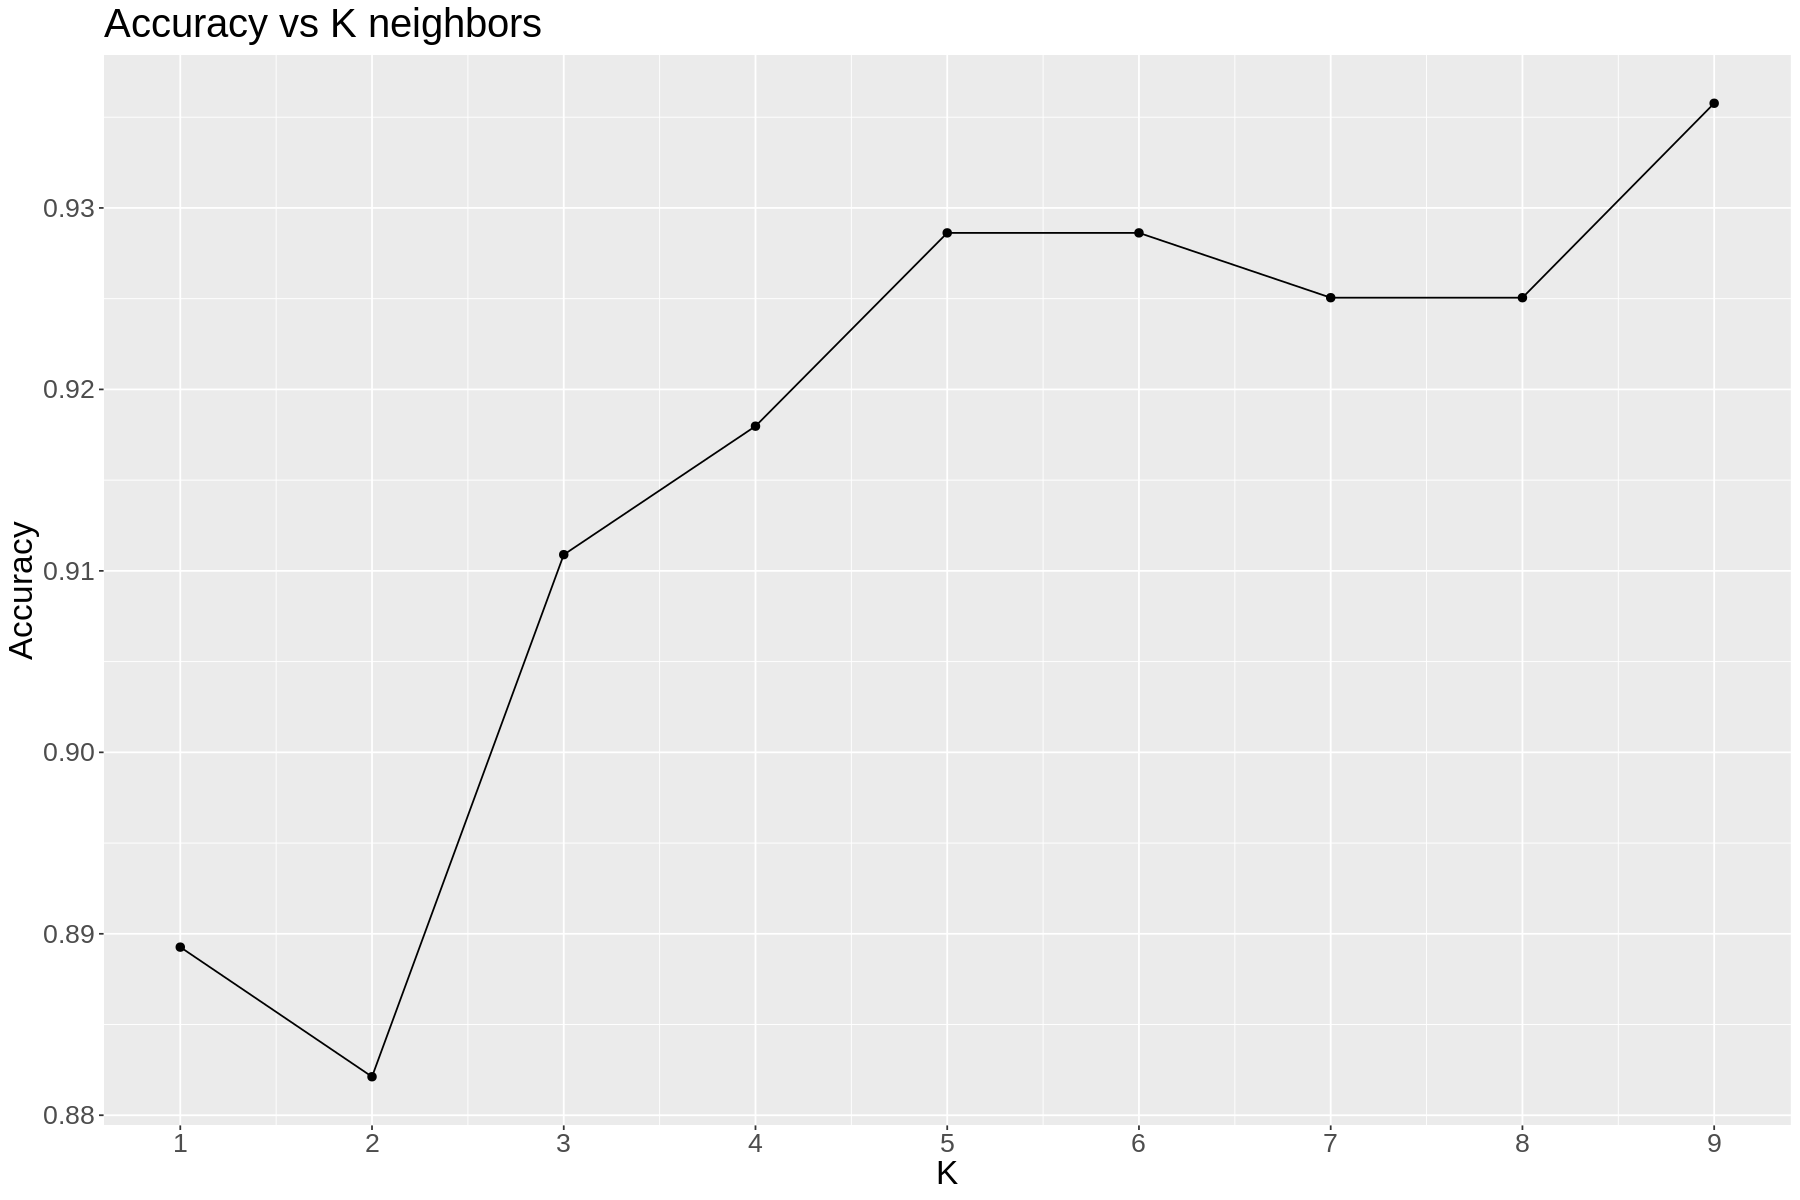

In [58]:
sleep_accuracy <- sleep_workflow |>
    filter(.metric == "accuracy")

sleep_accuracy_plot <- sleep_accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point(size = 2) +
    geom_line() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs K neighbors") +
    scale_x_continuous(breaks = 1:9) +
    theme(text = element_text(size = 20))

sleep_accuracy_plot

**Figure Legend**

Accuracy vs K neighbors line graph. The y-axis shows the accuracy of each K value on the x-axis. The optimal K value is that which scores the highest accuracy. Based on the plot, the best K value is 9, with a highest accuracy of 0.94.

In [61]:
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

In [70]:
fit_sleep <- workflow() |>
    add_recipe(sleep_recipe) |>
    add_model(final_spec) |>
    fit(data = sleep_train)

In [74]:
predict_sleep <- predict(fit_sleep, sleep_test) |>
    bind_cols(sleep_test)
head(predict_sleep)

.pred_class,Age,Sleep.Duration,Systolic.BP,Diastolic.BP,Diagnosis
<fct>,<dbl>,<dbl>,<int>,<int>,<chr>
None,31,7.7,120,80,Sleep Disorder
None,36,6.6,129,84,Sleep Disorder
Sleep Disorder,42,6.8,130,85,Sleep Disorder
Sleep Disorder,49,6.2,140,95,Sleep Disorder
Sleep Disorder,50,6.1,140,95,Sleep Disorder
Sleep Disorder,50,6.0,140,95,Sleep Disorder


In [75]:
final_accuracy <- predict_sleep |>
    metrics(truth = Diagnosis, estimate = .pred_class)
final_accuracy

ERROR: [1m[33mError[39m in [1m[1m`value[[3L]]()`:[22m
[33m![39m In metric: `rmse`
[1m[22mProblem while computing `.estimate = metric_fn(truth = Diagnosis,
estimate = .pred_class, na_rm = na_rm)`.
[1mCaused by error in [1m[1m`validate_class()`:[22m
[33m![39m `truth` should be a numeric but a character was supplied.


#### **References**
Tharmalingam, L. (2023, May 26). Sleep health and lifestyle dataset. Kaggle.    https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset 